In [2]:
import torch
import numpy as np
import d2lzh_pytorch as d2l

In [3]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)


In [4]:
print(labels.shape)

torch.Size([200])


In [5]:
def semilogy(x_vals,y_vals,x_label,y_label,x2_vals = None,y2_vals=None,
            legend=None,figsize=(3.5,2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals,y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals,y2_vals,linestyle=':')
        d2l.plt.legend(legend)

#### 和线性回归一样，多项式函数拟合也使用平方损失函数。因为我们将尝试使用不同复杂度的模型来拟合生成的数据集，所以我们把模型定义部分放在fit_and_plot函数中。多项式函数拟合的训练和测试步骤与3.6节介绍的softmax回归中的相关步骤类似

In [8]:
num_epochs,loss = 100,torch.nn.MSELoss()
def fit_and_plot(train_features,test_features,train_labels,test_labels):
    net = torch.nn.Linear(train_features.shape[-1],1)
    #通过Linear文档可知，pytorch已经将参数初始化了，所以我们在这里就不用手动初始化了
    
    batch_size = min(10,train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle = True)
    #优化器
    optimizer = torch.optim.SGD(net.parameters(),lr = 0.01)
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y.view(-1,1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1,1)
        test_labels = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features),train_labels).item())
        test_ls.append(loss(net(test_features),test_labels).item())
    print('final epoch: train loss',train_ls[-1],'test loss',test_ls[-1])
    semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',
            range(1,num_epochs+1),test_ls,['train','test'])
    print('weight:',net.weight.data,
         '\nbias',net.bias.data)

### 三阶多项式函数拟合（正常）

#### 我们先使用与数据生成函数同阶的三阶多项式函数拟合。实验证明，这个模型的训练误差和在测试数据集的误差都较低。训练出的模型参数也接近真实值

final epoch: train loss 0.0006142014171928167 test loss 0.0008175471448339522
weight: tensor([[ 1.2488, -3.3877,  5.5782]]) 
bias tensor([4.9938])


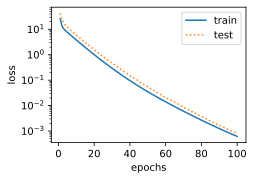

In [9]:
fit_and_plot(poly_features[:n_train,:],poly_features[n_train:,:],
            labels[:n_train],labels[n_train:])

#### 我们再试试 线性函数拟合。很明显，该模型的训练误差在迭代早期下降后便很难继续降低。在完成最后一次迭代周期后，训练误差依旧很高。线性模型在非线性模型如三阶多项式函数生成的数据集上容易欠拟合

final epoch: train loss 30.281606674194336 test loss 50.85490798950195
weight: tensor([[10.3654]]) 
bias tensor([3.5120])


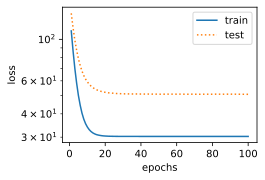

In [10]:
fit_and_plot(features[:n_train,:],features[n_train:,:],labels[:n_train],labels[n_train:])

### 训练样本不足 过拟合
#### 事实上，即便使用与数据生成模型同阶的三阶多项式函数模型，如果训练样本不足，该模型依然容易过拟合。让我们只使用两个样本来训练模型。显然，训练样本过少了，甚至少于模型参数的数量，这使得模型过于复杂，以至于容易被训练数据中的噪声影响。在迭代过程中，尽管训练误差较低，但是测试数据集上的误差却很高。这是典型的过拟合现象

final epoch: train loss 1.9447740316390991 test loss 4.092501163482666
weight: tensor([[ 0.3363, -2.2260,  6.0446]]) 
bias tensor([2.3740])


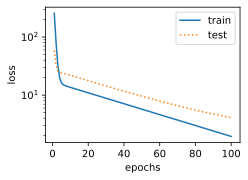

In [12]:
fit_and_plot(poly_features[0:2,:],poly_features[n_train:,:],labels[0:2],
            labels[n_train:])